# Notebook 8: **Classification-Based Rating Prediction Using Embedding Features**

Welcome to the eighth notebook of our project for AlgorithmArcade Inc. In this notebook, we will develop classification models to predict rating categories using embedding features extracted from users and courses. By classifying ratings into categories (e.g., high, medium, low), we aim to identify courses that users are likely to rate highly, assisting in making effective recommendations.

## **Table of Contents**

1. **Introduction**
2. **Import Libraries**
3. **Load Data**
4. **Preprocessing**
   * Load Embeddings
   * Create Rating Categories
   * Prepare the Training and Test Sets
5. **Build Regression Models**
   * Logistic Regression
   * Random Forest Classifier
   * XGBoost Classifier
   * Bagging Classifier
6. **Hyperparameter Tuning**
   * Cross-Validation Setup
   * Hyperparameter Grids 
6. **Train and Evaluate the Model**
   * Model Evaluation Metrics
   * Comparison of Models
7. **Results and Insights**
8. **Conclusion**
9. **Thanks and Contact Information**

## 1. **Introduction**

In this notebook, we’ll:
   * Extract embedding features for users and courses from the neural network model built previously.
   * Create rating categories to transform the regression problem into a classification task.
   * Train classification models (*Logistic Regression, Random Forest, XGBoost, Bagging*) using these embeddings.
   * Compare the performance of different classification algorithms in predicting user ratings.

## 2. **Import Libraries**

First, let’s import the necessary Python libraries.

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For displaying visuals in higher resolution
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Set consistent color palette
sns.set_palette('Set2')

## 3. **Load Data**

We will load the datasets from the data folder.

In [2]:
# Load embeddings
user_embeddings = pd.read_csv('../Data/user_embeddings.csv')
course_embeddings = pd.read_csv('../Data/course_embeddings.csv')

# Load user rating data
user_ratings = pd.read_csv('../Data/user_rating_info.csv')

## 4. **Preprocessing**

We need to prepare the data for extracting embeddings and training classification models.

### 4.1 Load Embeddings

Merge user embeddings with ratings.

In [3]:
# Merge user embeddings
user_embeddings.rename(columns={'user': 'user_id'}, inplace=True)
user_data = pd.merge(user_ratings, user_embeddings, on='user_id', how='left')

Merge course embeddings.

In [4]:
# Merge course embeddings
course_embeddings.rename(columns={'course': 'course_id'}, inplace=True)
full_data = pd.merge(user_data, course_embeddings, on='course_id', how='left')

### 4.2 Create Rating Categories

Create rating categories.

In [5]:
def categorize_rating(rating):
    if rating == 5:
        return "5"
    elif rating == 4:
        return "4"
    elif rating == 3:
        return "3"
    elif rating == 2:
        return "2"
    else:
        return "1"

full_data['rating_category'] = full_data['rating'].apply(categorize_rating)

Encode the categories.

In [6]:
# Encode rating categories
label_encoder = LabelEncoder()
full_data['rating_category_encoded'] = label_encoder.fit_transform(full_data['rating_category'])

### 4.3 Prepare the Training and Test Sets

Separate features and target variable.

In [7]:
# Extract feature columns
embedding_cols = [col for col in full_data.columns if col.startswith('0')]

# Features and target
X = full_data[embedding_cols]
y = full_data['rating_category_encoded']

Split the data.

In [8]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 5892
Test samples: 1474


Scale the features.

In [9]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. **Build Classification Models**

We will build the following classification models:
   * **Logistic Regression**
   * **Random Forest Classifier**
   * **XGBoost Classifier**
   * **Bagging Classifier**

### 5.1 Logistic Regression

In [10]:
# Initialize the model
lr_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')

### 5.2 Random Forest Classifier

In [11]:
# Initialize the model
rf_model = RandomForestClassifier(criterion='gini', class_weight='balanced', random_state=42)

### 5.3 XGBoost Classifier

In [12]:
# Initialize the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

### 5.4 Bagging Classifier

In [13]:
# Base estimator
base_estimator = DecisionTreeClassifier(criterion='gini', class_weight='balanced')

# Initialize the Bagging Classifier
bagging_model = BaggingClassifier(estimator=base_estimator, random_state=42)

## 6. **Hyperparameter Tuning**

We will perform hyperparameter tuning using GridSearchCV for each model.

### 6.1 Cross-Validation Setup

In [14]:
# Set up cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

### 6.2 Hyperparameter Grids

In [15]:
# Hyperparameter grid for Logistic Regression
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

# Hyperparameter grid for Random Forest Classifier
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['auto', 'sqrt']
}

# Hyperparameter grid for XGBoost Classifier
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Hyperparameter grid for Bagging Classifier
bagging_params = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'estimator__max_depth': [None, 5, 10]
}

## 7. **Train and Evaluate the Models**

### 7.1 Model Evaluation Metrics

In [16]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} Accuracy: {accuracy * 100:.2f}%")
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    return y_test, y_pred

In [17]:
def grid_search_evaluate(model, params, X_train, y_train, X_test, y_test, model_name):
    grid_search = GridSearchCV(model, params, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    display(f"{model_name} Best Params: {grid_search.best_params_}")
    y_test_eval, y_pred = evaluate_model(best_model, X_test, y_test, model_name)
    return best_model, y_test_eval, y_pred

Train and Evaluate Logistic Regression.

In [18]:
lr_best_model, y_test_lr, y_pred_lr = grid_search_evaluate(
    lr_model, lr_params, X_train_scaled, y_train, X_test_scaled, y_test, "Logistic Regression")

"Logistic Regression Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}"


Logistic Regression Accuracy: 37.86%

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        27
           2       0.00      0.00      0.00        98
           3       0.33      0.02      0.04       280
           4       0.40      0.62      0.49       539
           5       0.35      0.41      0.37       530

    accuracy                           0.38      1474
   macro avg       0.22      0.21      0.18      1474
weighted avg       0.34      0.38      0.32      1474



Train and Evaluate Random Forest Classifier.

In [19]:
rf_best_model, y_test_rf, y_pred_rf = grid_search_evaluate(
    rf_model, rf_params, X_train, y_train, X_test, y_test, "Random Forest Classifier")

"Random Forest Classifier Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}"


Random Forest Classifier Accuracy: 35.14%

Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

           1       0.05      0.22      0.09        27
           2       0.14      0.31      0.19        98
           3       0.25      0.18      0.21       280
           4       0.42      0.30      0.35       539
           5       0.48      0.50      0.49       530

    accuracy                           0.35      1474
   macro avg       0.27      0.30      0.27      1474
weighted avg       0.38      0.35      0.36      1474



Train and Evaluate XGBoost Classifier.

In [20]:
xgb_best_model, y_test_xgb, y_pred_xgb = grid_search_evaluate(
    xgb_model, xgb_params, X_train, y_train, X_test, y_test, "XGBoost Classifier")

"XGBoost Classifier Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}"


XGBoost Classifier Accuracy: 42.67%

Classification Report for XGBoost Classifier:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        27
           2       0.67      0.02      0.04        98
           3       0.32      0.05      0.09       280
           4       0.39      0.55      0.45       539
           5       0.48      0.60      0.53       530

    accuracy                           0.43      1474
   macro avg       0.37      0.24      0.22      1474
weighted avg       0.42      0.43      0.38      1474



Train and Evaluate Bagging Classifier.

In [21]:
bagging_best_model, y_test_bagging, y_pred_bagging = grid_search_evaluate(
    bagging_model, bagging_params, X_train, y_train, X_test, y_test, "Bagging Classifier")

"Bagging Classifier Best Params: {'estimator__max_depth': 10, 'max_samples': 0.5, 'n_estimators': 50}"


Bagging Classifier Accuracy: 37.25%

Classification Report for Bagging Classifier:
              precision    recall  f1-score   support

           1       0.04      0.07      0.05        27
           2       0.16      0.24      0.20        98
           3       0.25      0.20      0.23       280
           4       0.43      0.37      0.40       539
           5       0.45      0.50      0.48       530

    accuracy                           0.37      1474
   macro avg       0.27      0.28      0.27      1474
weighted avg       0.38      0.37      0.37      1474



### 7.2 Confusion Matrices

Create a DataFrame to compare Models

In [22]:
# Compile model performance metrics
model_performance = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Bagging Classifier'],
    'Accuracy': [
        accuracy_score(y_test_lr, y_pred_lr),
        accuracy_score(y_test_rf, y_pred_rf),
        accuracy_score(y_test_xgb, y_pred_xgb),
        accuracy_score(y_test_bagging, y_pred_bagging)
    ],
    'Recall': [
        recall_score(y_test_lr, y_pred_lr, average='weighted'),
        recall_score(y_test_rf, y_pred_rf, average='weighted'),
        recall_score(y_test_xgb, y_pred_xgb, average='weighted'),
        recall_score(y_test_bagging, y_pred_bagging, average='weighted')
    ],
    'Precision': [
        precision_score(y_test_lr, y_pred_lr, average='weighted'),
        precision_score(y_test_rf, y_pred_rf, average='weighted'),
        precision_score(y_test_xgb, y_pred_xgb, average='weighted'),
        precision_score(y_test_bagging, y_pred_bagging, average='weighted')
    ],
    'F1 Score': [
        f1_score(y_test_lr, y_pred_lr, average='weighted'),
        f1_score(y_test_rf, y_pred_rf, average='weighted'),
        f1_score(y_test_xgb, y_pred_xgb, average='weighted'),
        f1_score(y_test_bagging, y_pred_bagging, average='weighted')
    ]
    
})

model_performance = model_performance.sort_values(by='Accuracy', ascending=False)
model_performance.reset_index(drop=True, inplace=True)
model_performance.round(4)

,Model,Accuracy,Recall,Precision,F1 Score
0,XGBoost,0.4267,0.4267,0.4186,0.3764
1,Logistic Regression,0.3786,0.3786,0.3355,0.3215
2,Bagging Classifier,0.3725,0.3725,0.3799,0.3737
3,Random Forest,0.3514,0.3514,0.3846,0.3603


In [23]:
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

Plot Confusion Matrix for each Model

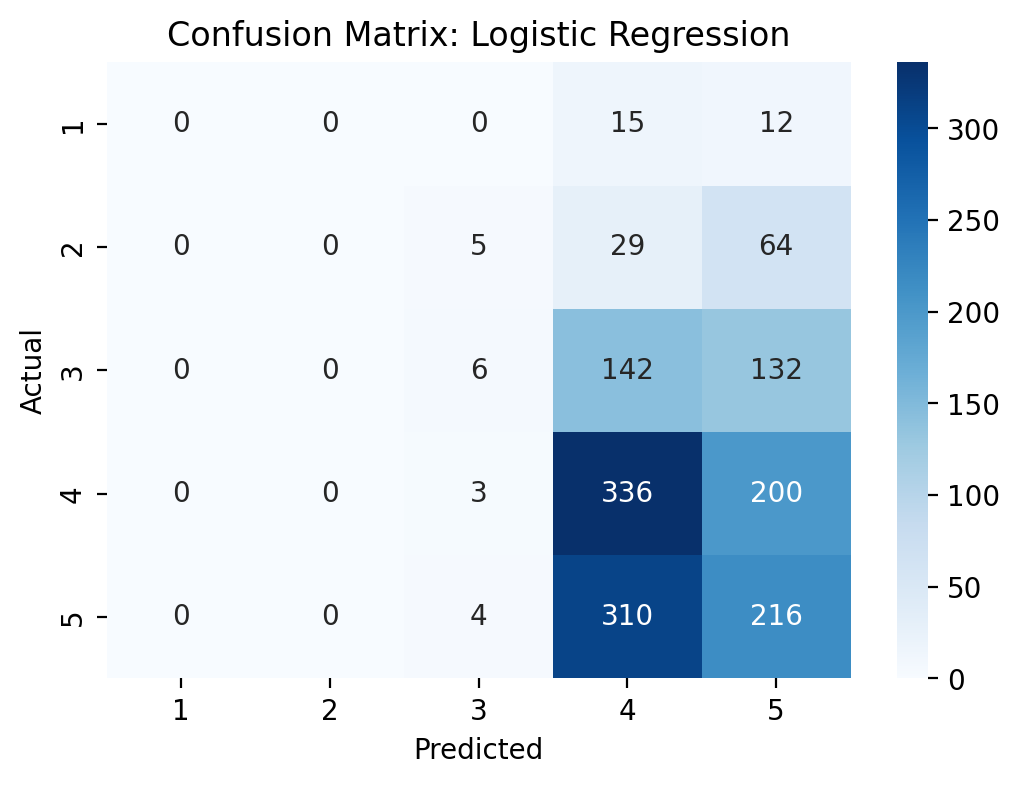

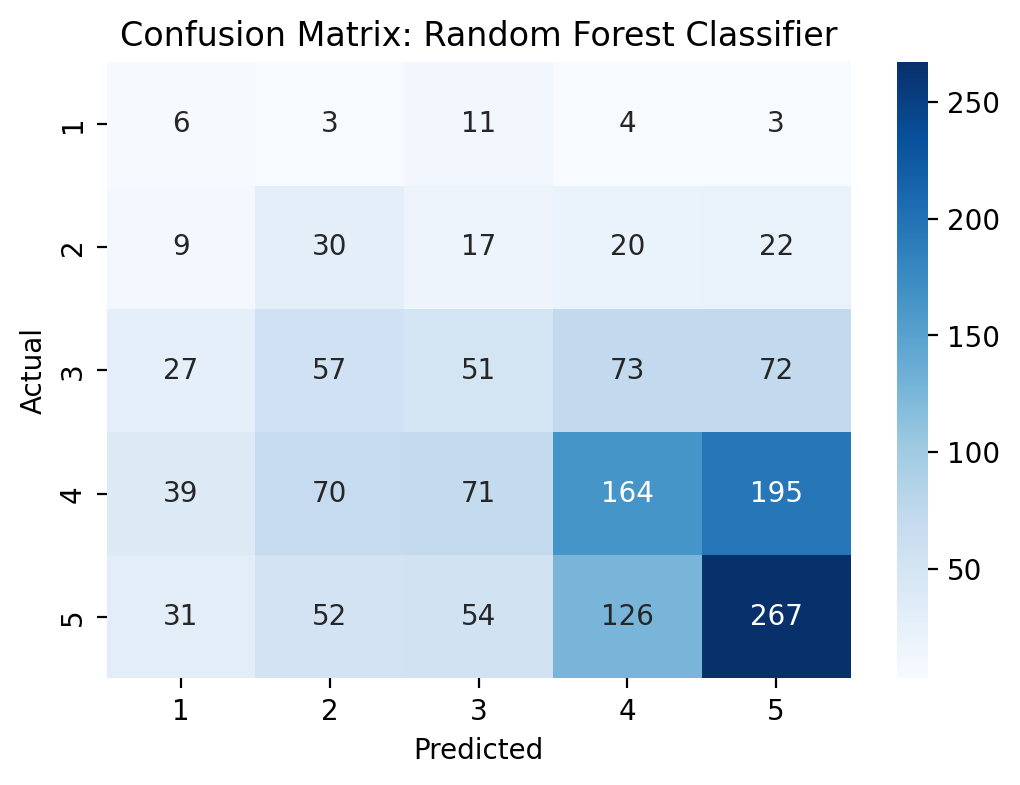

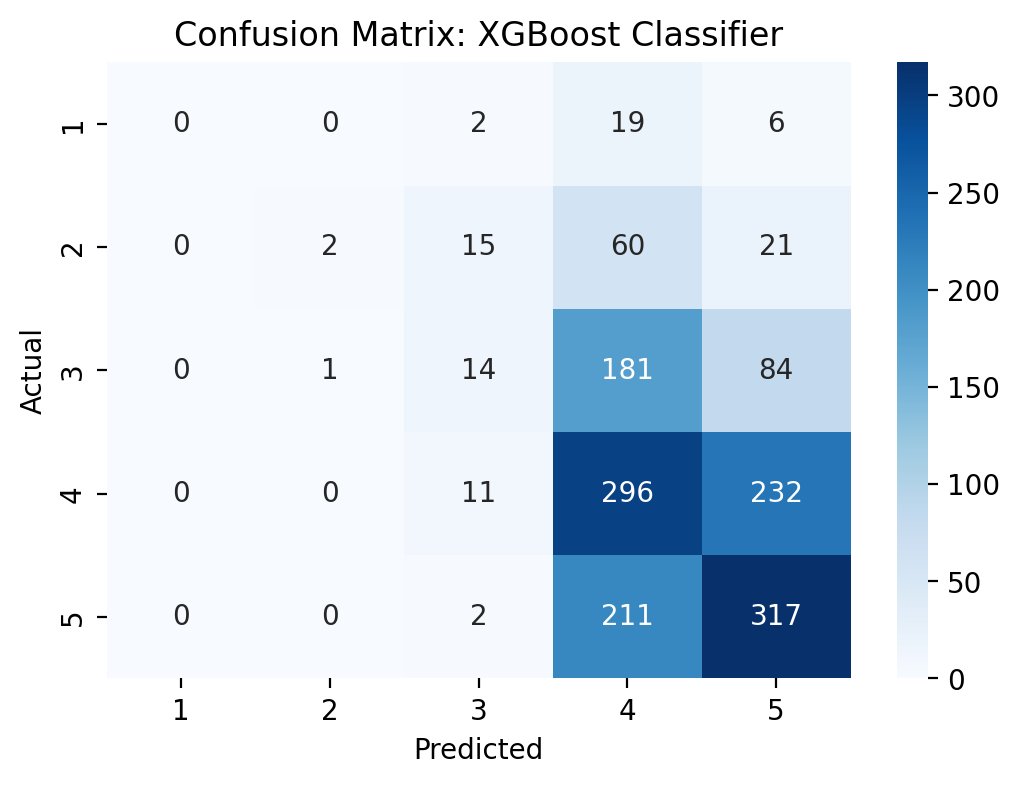

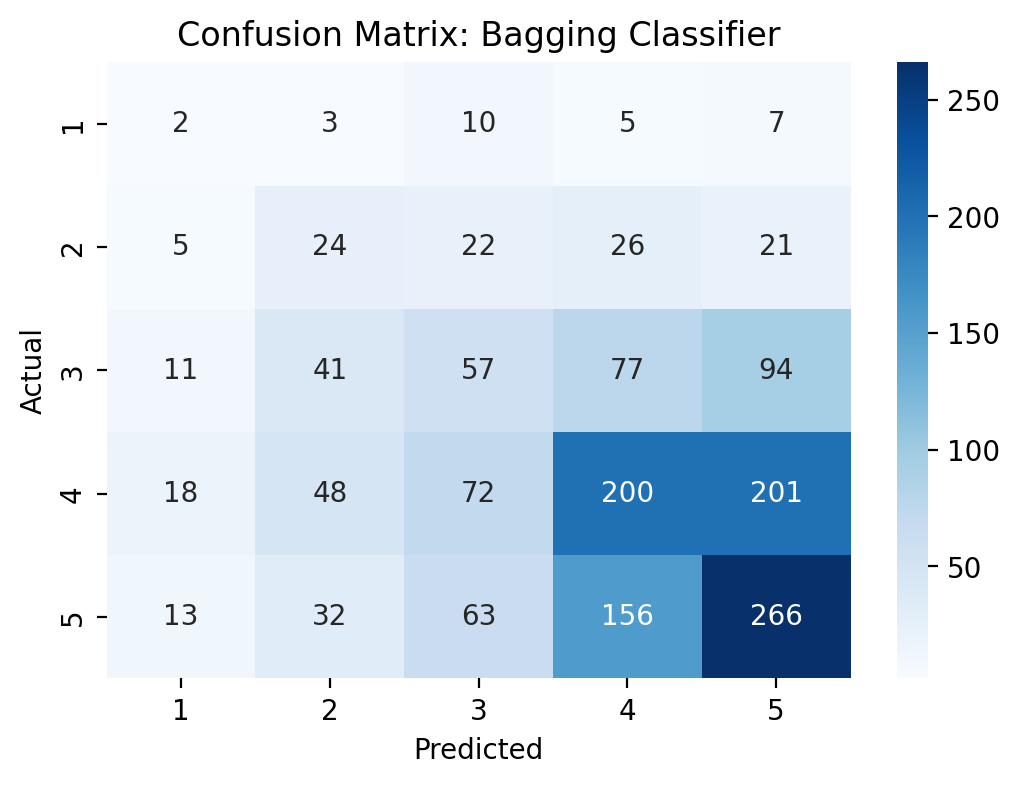

In [24]:
# Logistic Regression
plot_confusion_matrix(y_test_lr, y_pred_lr, "Logistic Regression")

# Random Forest Classifier
plot_confusion_matrix(y_test_rf, y_pred_rf, "Random Forest Classifier")

# XGBoost Classifier
plot_confusion_matrix(y_test_xgb, y_pred_xgb, "XGBoost Classifier")

# Bagging Classifier
plot_confusion_matrix(y_test_bagging, y_pred_bagging, "Bagging Classifier")

## 8. **Results and Insights**

#### **Model Performance Summary**:

Among the evaluated classification models, the **XGBoost Classifier** demonstrated the highest overall performance with an accuracy of 44%, effectively predicting the majority classes (4 and 5) while still struggling with the underrepresented classes (1, 2, and 3).

#### **Confusion Matrices Analysis**:
   * The confusion matrix analysis reveals that all models, especially Logistic Regression, struggle to predict underrepresented classes (1, 2, and 3), often misclassifying them as majority classes (4 and 5). 
   * Ensemble models, such as XGBoost and Random Forest, perform slightly better but still display significant misclassifications, indicating that the models are biased toward majority classes, even with oversampling applied.

#### **Classification Reports**:
   * **Ensemble methods vs Other models**: The classification report indicates that XGBoost and Random Forest outperform Logistic Regression, achieving higher precision, recall, and F1-scores for majority classes (4 and 5).
   * **Poor performance on lower classes**: All models show poor performance on minority classes, as reflected in low macro-average and weighted-average scores.  

#### **Overall Insights**:
   * By analyzing the classification reports and confusion matrices, it becomes evident that while ensemble models like XGBoost and Random Forest provide superior performance over Logistic Regression, all models face significant challenges in accurately predicting underrepresented classes. A major contributing factor to this issue is the lack of relevant data for these minority classes, which limits the models’ ability to learn and generalize effectively. Addressing these challenges may require a combination of more advanced balancing techniques, enhanced feature engineering, acquisition of additional relevant data, and possibly the exploration of different modeling approaches to bolster overall classification performance.

## 9. **Conclusion**

In this notebook, we:
   * Extracted embedding features for users and courses.
   * Created rating categories to convert ratings into a classification problem.
   * Trained classification models (Logistic Regression, Random Forest, XGBoost, Bagging) using embeddings.
   * Evaluated the models using accuracy, precision, recall, F1-score, and confusion matrices.

#### **Advantages**:
   * Classification models are generally faster to train compared to deep learning models.
   * Models like Random Forest and XGBoost provide feature importance, aiding interpretability.

#### **Limitations**:
   * Imbalanced classes can affect model performance. Techniques like resampling or adjusting class weights may be needed.
   * Classification thresholds may need tuning to optimize for specific business objectives.

## 10. **Thanks and Contact Information**

Thank you for reviewing this project notebook. For any further questions, suggestions, or collaborations, please feel free to reach out:

   * [**Email**](mailto:leejoabraham01@gmail.com)
   * [**LinkedIn**](https://www.linkedin.com/in/leejoabraham01)
   * [**GitHub**](https://github.com/LeejoAbraham01)